In [1]:
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def generate_fire_degradation_rate(veg):
    # Define the range for fire_degradation_rate based on the veg parameter
    min_rate, max_rate = 0.8, 8

    # Interpolate linearly between the min_rate and max_rate based on veg
    fire_degradation_rate = min_rate + veg * (max_rate - min_rate)
    
    return fire_degradation_rate

def generate_grid(n, m, default_density=(1, 0), init_fire = 0, water=True, block=True, csv_filename=None):
    #set init_fire to be number of nodes you want to start the fire at initially. 
    #n is dimension of square grid, m is number of areas of different types to generate
    # Create an empty grid
    grid = [[None] * n for _ in range(n)]

    # Define the area types
    area_types = [
        {'housing_density': 1, 'vegetation_density': 0},
        {'housing_density': 1, 'vegetation_density': 1},
        {'housing_density': 2, 'vegetation_density': 0},
        {'housing_density': 2, 'vegetation_density': 1},
        {'housing_density': 3, 'vegetation_density': 0},
        {'housing_density': 3, 'vegetation_density': 1},
        {'housing_density': 4, 'vegetation_density': 0},
        {'housing_density': 4, 'vegetation_density': 1},
        {'housing_density': 5, 'vegetation_density': 0},
        {'housing_density': 5, 'vegetation_density': 1}
    ]
    
    if water:
        area_types.append({'housing_density': 0, 'vegetation_density': 'w'})
        
    if block:
        area_types.append({'housing_density': -1, 'vegetation_density': 'b'})

    # Create m rectangular areas
    for _ in range(m):
        area_type = random.choice(area_types)
        area_width = random.randint(1, n // 3)  # Random width (at most 1/3 of n)
        area_height = random.randint(1, n // 3)  # Random height (at most 1/3 of n)
        start_row = random.randint(0, n - area_height)  # Random starting row index
        start_col = random.randint(0, n - area_width)  # Random starting column index

        # Assign the area type to the grid cells
        for i in range(start_row, start_row + area_height):
            for j in range(start_col, start_col + area_width):
                grid[i][j] = area_type

    # Fill in the remaining cells with the default area type
    default_area = {'housing_density': default_density[0], 'vegetation_density': default_density[1]}
    for i in range(n):
        for j in range(n):
            if grid[i][j] is None:
                grid[i][j] = default_area

    # Generate CSV data
    csv_data = []
    node_id = 1
    for i in range(n):
        for j in range(n):
            area = grid[i][j]
            
            #coordinates are assigned as centers of cells
            x_coordinate = j + 0.5
            y_coordinate = i + 0.5
            
            #value at start is assigned to be higher as housing density increases
            housing_density = area['housing_density']
            if housing_density == 0: #water
                value_at_start = 0
            elif housing_density == -1: #block
                value_at_start = -1
            elif housing_density == 1: #0
                value_at_start = 1
            elif housing_density == 2: #<6
                value_at_start = random.uniform(1,2)
            elif housing_density == 3: #6-50
                value_at_start = random.uniform(2,4)
            elif housing_density == 4: #50-741
                value_at_start = random.uniform(4,10)
            elif housing_density == 5: #>741
                value_at_start = 10
                
            #"veg" is randomly assigned to be b/w 0 and 0.5 if vegetation density is 0, and b/w 0.5 and 1 otherwise
            vegetation_density = area['vegetation_density']
            if vegetation_density == 'w' or vegetation_density == 'b': #water or block
                veg = 0
            elif vegetation_density == 0:
                veg = round(random.uniform(0, 0.5), 2)
            else:
                veg = round(random.uniform(0.5, 1), 2)
                
            #then, fire degradation rate and fire amelioration rate are assigned based on veg; higher veg - faster fire
            if vegetation_density == 'w' or vegetation_density == 'b': #water or block
                fire_degradation_rate = 0
                fire_amelioration_rate = 0
            else: 
                fire_degradation_rate = generate_fire_degradation_rate(veg) #value b/w 0.8 and 8
                fire_amelioration_rate = round(random.uniform(fire_degradation_rate-0.5, fire_degradation_rate+0.5), 2)/2 #value b/w 0.4 and 4
                if fire_amelioration_rate > 4:
                    fire_amelioration_rate = 4
                elif fire_amelioration_rate <= 0.4:
                    fire_amelioration_rate = 0.4 
            
            #value degradation is also assigned based on the above rates: faster the fire, faster the value deteriorates
            if vegetation_density == 'w' or vegetation_density == 'b': #water or block
                value_degradation_rate = 0
            else:
                value_degradation_rate =  value_at_start / (1/fire_degradation_rate + 1/fire_amelioration_rate)

            neighborhood_list = []
            if i > 0:
                neighborhood_list.append((i - 1) * n + j + 1)  # Above cell
            if i < n - 1:
                neighborhood_list.append((i + 1) * n + j + 1)  # Below cell
            if j > 0:
                neighborhood_list.append(i * n + j)  # Left cell
            if j < n - 1:
                neighborhood_list.append(i * n + j + 2)  # Right cell
                
            #assigning state value:
            if vegetation_density == 'w':
                state = 5
            elif vegetation_density == 'b':
                state = 4
            elif x_coordinate == 0.5 and y_coordinate == 0.5:
                state = 6
            else: 
                state = 1 if random.random() < init_fire/(n**2) else 0
    

            csv_data.append([
                node_id, x_coordinate, y_coordinate, value_at_start,
                value_degradation_rate, fire_degradation_rate,
                fire_amelioration_rate, neighborhood_list, state
            ])

            node_id += 1

    # Write CSV file
    if csv_filename:
        with open(csv_filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                'node_id', 'x_coordinate', 'y_coordinate', 'value_at_start',
                'value_degradation_rate', 'fire_degradation_rate',
                'fire_amelioration_rate', 'neighborhood_list', 'state'
            ])
            writer.writerows(csv_data)

    # Plot the grid
    plt.figure(figsize=(6, 6))
    plt.imshow([[area['housing_density'] for area in row] for row in grid], cmap='RdYlBu_r', vmin=0, vmax=5, origin = 'lower')
    plt.colorbar(label='Housing Density')
    veg = [[None] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            veg[i][j] = grid[i][j]['vegetation_density']
    for i in range(n):
        for j in range(n):
            plt.annotate(veg[i][j], xy=(j, i), ha='center', va='center')

    plt.title('Density Grid')
    plt.show()
    
    return pd.DataFrame(csv_data)



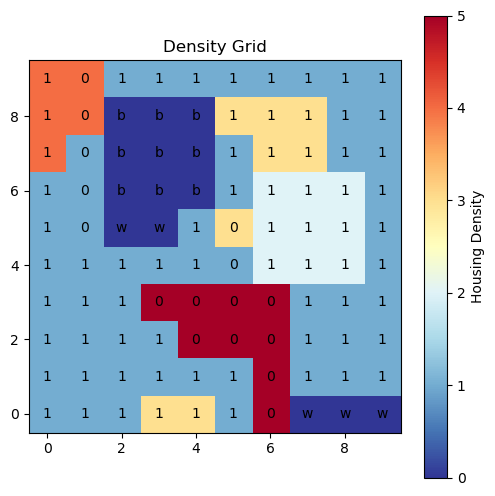

In [3]:
size = 10
df = generate_grid(size, 20, default_density=(1, 1), init_fire = 10, csv_filename='WUI_scenario.csv')

In [4]:
def normalize_value(original_value, min_value, max_value):
    return (original_value - min_value) / (max_value - min_value)

#Generate RBG map based on value_at_start
def get_rgb_val(number):
    if number == 0:
        return (0, 100, 150)
    elif number == -1:
        return (255, 255, 255)
    elif 1 <= number <= 10:
        # Calculate the green shade based on the input number
        norm_number = normalize_value(number, 1, 10)
        green_value = 200 - int(100*norm_number)
        return (25, green_value, 75)
    else:
        raise ValueError("Number must be 0, -1, or in the range of 1 to 10")
        
val = [[None] * size for _ in range(size)]
idd = 0
for i in range(size):
    for j in range(size):
        val[i][j] = get_rgb_val(df[3][idd])
        idd += 1

#Generate RGB map based on fire_degradation_rate
def get_rgb_deg(number):
    norm_number = normalize_value(number, 0.8, 8)
    red_value = 200 - int(150*norm_number)
    return (red_value, 25, 25)

deg = [[None] * size for _ in range(size)]
idd = 0
for i in range(size):
    for j in range(size):
        if df[5][idd] == 0 and df[3][idd] == 0:
            deg[i][j] = (0, 100, 150)
        elif df[5][idd] == 0 and df[3][idd] == -1:
            deg[i][j] = (255, 255, 255)
        else:
            deg[i][j] = get_rgb_deg(df[5][idd])
        idd += 1

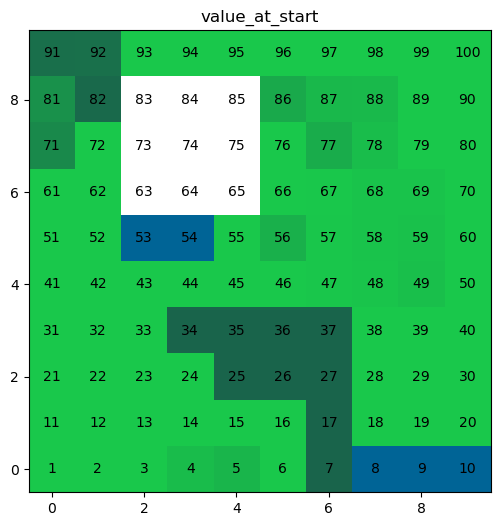

In [5]:
#Plot value_at_start

plt.figure(figsize=(6, 6))
plt.imshow(val, origin = "lower")
cell_count = 1
for i in range(size):
    for j in range(size):
        plt.annotate(cell_count, xy=(j, i), ha='center', va='center')
        cell_count += 1
plt.title('value_at_start')
plt.show()

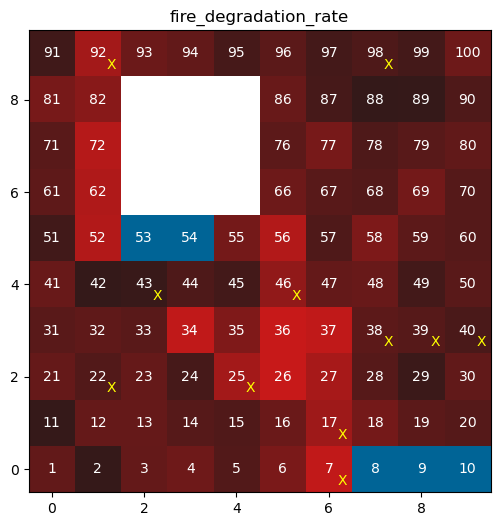

In [6]:
#Plot fire_degradation_rate


plt.figure(figsize=(6, 6))
plt.imshow(deg, origin = "lower")
cell_count = 1
for i in range(size):
    for j in range(size):
        plt.annotate(cell_count, xy=(j, i), ha='center', va='center', color = "white")
        if df[8][cell_count-1] == 1:
            plt.annotate("X", xy=(j+0.4, i-0.4), ha='right', va='bottom', color = "yellow")
        cell_count += 1
plt.title('fire_degradation_rate')
plt.show()